<center><h1>Datos Meteorológicos con Métodos de Interpolación</h1></center>  
<center><img src="clima.png" width=270 height=270></center>  

### **Sección: 305C1**
### **Estudiantes:**
Manuel Nava 30.822.007  
Juan Wu 30.391.117  
José Farrauto 30.696.288  

---

## Interpolación de Taylor

In [11]:
using Plots
using SymPy


#Temperaturas de prueba
baja = np.array([10,7,4,3,5,2,2]) #Temperaturas bajas 
alta = np.array([21,18,12,11,14,13,10]) #Temperaturas altas

#Declaramos el vector para guardar las temperaturas medias de cada dia
temp_medias=zeros(length(alta))

for i in 1:length(alta)
    temp_medias[i]= (alta[i]+baja[i])/2
end
print("Las temperaturas medias de cada dia son: ")
println(temp_medias)
#Declaramos el vector de dias
dias=1:length(temp_medias)

function Interpolacion_y_prediccion(temp_medias, dias,x0)
    # Variables simbólicas
    x = symbols("x")
    n = length(dias)
    
    # Diferencias finitas
    diferencias = [temp_medias]
    for i in 1:(n-1)
        push!(diferencias, diff(diferencias[end]))
    end
 
    # Construcción del polinomio de Taylor
    polinomio_de_Taylor = diferencias[1][1]
    factorial = 1
    for i in 1:(n-1)
        factorial *= i
        term = diferencias[i+1][1] / factorial
        for j in 0:(i-1)
            term *= (x - dias[j+1])
        end
        polinomio_de_Taylor += term
    end
    
    # Predicción en x0 que tomamos como 2.4
    prediccion = subs(polinomio_de_Taylor, x, x0)
    
    return polinomio_de_Taylor, prediccion,x0
end


# Calcular la interpolación de Taylor y predecir sobre x0
taylor, prediccion, x0 = Interpolacion_y_prediccion(temp_medias, dias,2.4)

#Imprimimos nuestra prediccion
println("La predicción sobre el punto x0 es: $prediccion ")


# Graficamos la funcion de temperaturas por los dias y el polinomio de taylor
plot(dias, temp_medias, label="Datos originales", lw=2, marker=:o)
plot!(taylor, label="Interpolación de Taylor", lw=2)
xlabel!("Días")
ylabel!("Temperatura (°C)")
title!("Interpolación de Taylor")
ylims!(0, 30)
xlims!(1, 8)


MethodError: MethodError: no method matching *(::String, ::Vector{Float64})

Closest candidates are:
  *(::Any, ::Any, !Matched::Any, !Matched::Any...)
   @ Base operators.jl:587
  *(!Matched::PyObject, ::Any)
   @ PyCall C:\Users\manue\.julia\packages\PyCall\1gn3u\src\pyoperators.jl:13
  *(::Any, !Matched::PyObject)
   @ PyCall C:\Users\manue\.julia\packages\PyCall\1gn3u\src\pyoperators.jl:14
  ...


---

## Interpolación de Lagrange

Temperatura de Tokyo: desde el día 23 al 29
Fuente: https://www.accuweather.com/es/jp/tokyo/226396/december-weather/226396?year=2023

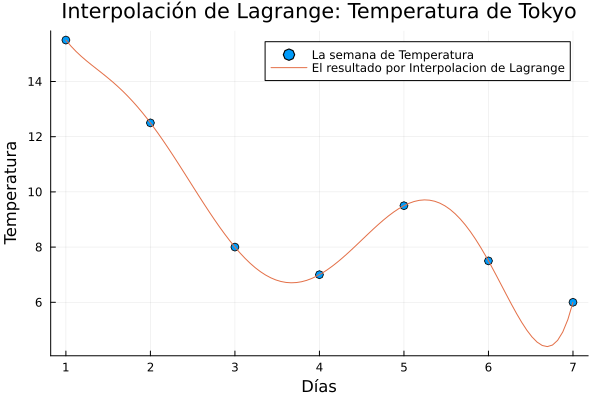

In [3]:
#=Importar libreria necesaria=#
using PyCall
using Plots
np = pyimport("numpy")

#=Datos de prueba=#
baja = np.array([10,7,4,3,5,2,2]) #=Temperatura baja=# 
alta = np.array([21,18,12,11,14,13,10]) #=Temperatura alta=#

#=Variables para trabajar:=#
dias = length(baja) #Esto es para contar cuanto dias
promedio_T = np.zeros(dias)
dias_lista = np.zeros(dias)

#Sacar promedio de temperatura
for i in 1:dias
    promedio_T[i]= (alta[i]+baja[i])/2
end

#=Contar cantidad de dias=#
j = 1
for i in 1:dias
    dias_lista[i] = j
    j = j + 1
end

#Procedimiento para el Interpolacion de Lagrange:

#Sacar el valor el vector "X":
menordias = np.min(dias_lista)
mayordias = np.max(dias_lista)
xpp = np.linspace(menordias, mayordias, 100)

#Sacar el valor el vector "Y":
ypp = np.zeros(length(xpp))
for i in 1:dias
    acum_p = np.ones(length(xpp)) #Para acumular el valor de y
    for j in 1:dias
        if i != j
            acum_p .*= ((xpp .- dias_lista[j] ) ./ (dias_lista[i]- dias_lista[j]))
        end
    end
    ypp .+= promedio_T[i] .* acum_p
end
#Colocar Fuente para Temperatura de Tokyo:
println("Temperatura de Tokyo: desde el día 23 al 29")
print("Fuente: https://www.accuweather.com/es/jp/tokyo/226396/december-weather/226396?year=2023")

#Grafica
scatter(dias_lista, promedio_T, marker=:o, label="La semana de Temperatura") #Ubicar los puntos sobre el dia y su correspondiente temperatura
plot!(xpp,ypp,label="El resultado por Interpolacion de Lagrange") #Graficar el vector
xlabel!("Días")
ylabel!("Temperatura")
title!("Interpolación de Lagrange: Temperatura de Tokyo")

---

## Interpolación de Hermite

---

## Interpolación Polinómicas a Trozos

<center><h2>Gracias!!</h2></center>